<a href="https://www.kaggle.com/code/gemmin/speech-emotion-recognition-90?scriptVersionId=257597969" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Speech Emotion Recognition

The objective of this notebook is to classify from raw sound waves to six emotions: happy, sad, neutral, fear, angry, and disgust. 

1. Gathering data
2. EDA
3. Preprocess
4. Extract features
5. Build LSTM
6. Evaluate

Datasets:
* Crema-D
* Ravdess
* Savee
* Tessa

# 1. Gathering data

We will gather speech data from four datasets and store it in a single dataframe along with the corresponding file paths, gender labels and emotion labels. The size of each respective dataframe will be specified, along with an example filename in which the emotion label is bolded. 

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
RAVDESS = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
CREMA = "/kaggle/input/cremad/AudioWAV/"
TESS = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
SAVEE = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"
EMODB = "/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/"

**1. Ravdess Dataframe**

There are 1440 audio files, for example, 03-01-**06**-01-02-01-12.wav.

In [3]:
ravdess_dir_lis = os.listdir(RAVDESS)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    '03' : 'happy',
    '01' : 'neutral',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fear',
    '07' : 'disgust',
}

for directory in ravdess_dir_lis:
    actor_files = os.listdir(os.path.join(RAVDESS, directory))
    for audio_file in actor_files: 
        part = audio_file.split('.')[0]
        key = part.split('-')[2]
        if key in emotion_dic:
            gender_code = int(part.split('-')[6])
            path_list.append(f"{RAVDESS}{directory}/{audio_file}")
            gender_list.append('female' if gender_code & 1 == 0 else 'male')
            emotion_list.append(emotion_dic[key])
            
ravdess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

ravdess_df.head()

,path,sex,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
1,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
2,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
3,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
4,/kaggle/input/ravdess-emotional-speech-audio/a...,female,fear


**2. Crema-D Dataframe**

There are 7,442 audio files, for example, 1001_DFA_**ANG**_XX.wav.

In [4]:
crema_dir_list = os.listdir(CREMA)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'HAP' : 'happy',
    'NEU' : 'neutral',
    'SAD' : 'sad',
    'ANG' : 'angry',
    'FEA' : 'fear',
    'DIS' : 'disgust',
}

female_id_list = [
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018', 
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047', 
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072', 
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
]

for audio_file in crema_dir_list:
    part = audio_file.split('_')
    key = part[2]
    if key in emotion_dic and part[3] == 'HI.wav': # _HI.wav indicates better quality
        path_list.append(f"{CREMA}{audio_file}")
        gender_list.append('female' if part[0] in female_id_list else 'male')
        emotion_list.append(emotion_dic[key])

crema_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

crema_df.head()

,path,sex,emotion
0,/kaggle/input/cremad/AudioWAV/1032_IEO_HAP_HI.wav,male,happy
1,/kaggle/input/cremad/AudioWAV/1076_IEO_FEA_HI.wav,female,fear
2,/kaggle/input/cremad/AudioWAV/1056_IEO_ANG_HI.wav,female,angry
3,/kaggle/input/cremad/AudioWAV/1038_IEO_SAD_HI.wav,male,sad
4,/kaggle/input/cremad/AudioWAV/1043_IEO_DIS_HI.wav,female,disgust


**3. Tess Dataframe**

There are 2,800 audio files, for example, OAF_base_**fear**.wav.

In [5]:
tess_dir_list = os.listdir(TESS)
path_list = []
gender_list = []
emotion_list = [] 

emotion_dic = {
    'happy'   : 'happy',
    'neutral' : 'neutral',
    'sad'     : 'sad',
    'Sad'     : 'sad',
    'angry'   : 'angry',
    'fear'    : 'fear',
    'disgust'  : 'disgust',
}

for directory in tess_dir_list:
    audio_files = os.listdir(os.path.join(TESS, directory))
    for audio_file in audio_files:
        part = audio_file.split('.')[0]
        key = part.split('_')[2]
        if key in emotion_dic:
            path_list.append(f"{TESS}{directory}/{audio_file}") 
            gender_list.append('female') # female only dataset
            emotion_list.append(emotion_dic[key])
            
tess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

tess_df.head()

,path,sex,emotion
0,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear


**4. Savee Dataframe**

There are 480 audio files, for example, DC_**a**02.wav.

In [6]:
savee_dir_list = os.listdir(SAVEE)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'h'  : 'happy',
    'n'  : 'neutral',
    'sa' : 'sad',
    'a'  : 'angry',
    'f'  : 'fear',
    'd'  : 'disgust'
}

for audio_file in savee_dir_list:
    part = audio_file.split('_')[1]
    key = part[:-6]
    if key in emotion_dic:
        path_list.append(f"{SAVEE}{audio_file}")
        gender_list.append('male') # male only dataset
        emotion_list.append(emotion_dic[key])
        
savee_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

savee_df.head()

,path,sex,emotion
0,/kaggle/input/surrey-audiovisual-expressed-emo...,male,happy
1,/kaggle/input/surrey-audiovisual-expressed-emo...,male,fear
2,/kaggle/input/surrey-audiovisual-expressed-emo...,male,happy
3,/kaggle/input/surrey-audiovisual-expressed-emo...,male,disgust
4,/kaggle/input/surrey-audiovisual-expressed-emo...,male,angry


In [7]:
df = pd.concat([
    ravdess_df, 
    crema_df, 
    tess_df, 
    savee_df, 
], axis=0)
df.head()

,path,sex,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
1,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
2,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
3,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
4,/kaggle/input/ravdess-emotional-speech-audio/a...,female,fear


# 2. Quick EDA

We check for imbalances like male to female ratio. 

In [8]:
import librosa
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [9]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4331 entries, 0 to 419
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   path     4331 non-null   object
 1   sex      4331 non-null   object
 2   emotion  4331 non-null   object
dtypes: object(3)
memory usage: 135.3+ KB


,path,sex,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
1,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
2,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
3,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
4,/kaggle/input/ravdess-emotional-speech-audio/a...,female,fear


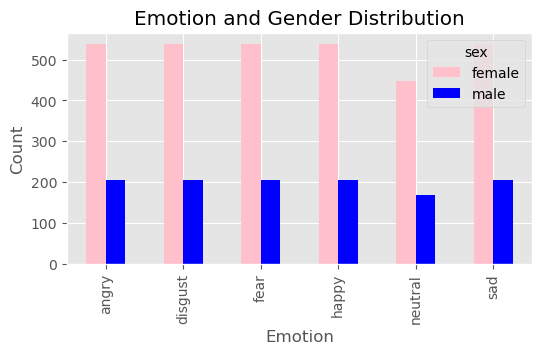

In [10]:
def plot_distribution(df): 
    countTable = df.groupby(['emotion', 'sex']).count()
    pivotTable = countTable.pivot_table(index='emotion', columns='sex', values='path')

    pivotTable.plot(kind='bar', figsize=(6, 3), color=['pink', 'blue'])
    plt.title('Emotion and Gender Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()
    
plot_distribution(df)

Slight imbalances, but I think we have enough data. Let's see some sample data. 

In [11]:
from IPython.display import Audio

def create_waveplot(y, sr, title):
    plt.figure(figsize=(8, 2))
    plt.title(title)
    librosa.display.waveshow(y, sr=sr)
    plt.show()

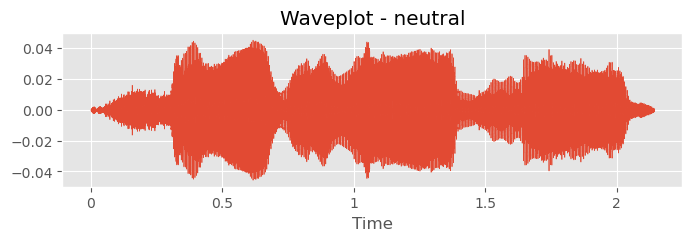

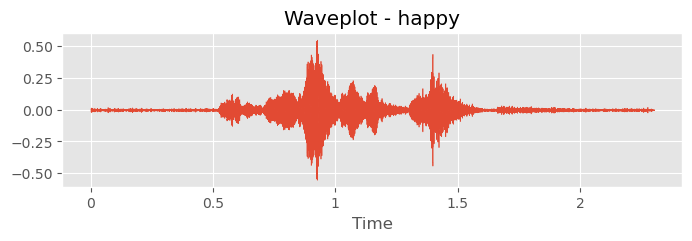

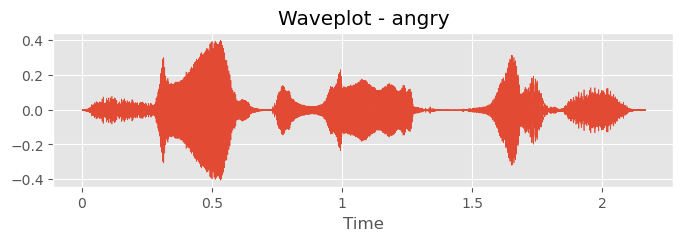

In [12]:
sample_size = 3
sample_df = df.sample(n=sample_size, random_state=42)

for idx, row in sample_df.iterrows():
   emotion_label = row['emotion']
   path = row['path']
   
   y, sr = librosa.load(path)
   create_waveplot(y, sr, f"Waveplot - {emotion_label}")
   
   display(Audio(path))
   print("\n")

# 3. Preprocess

The following steps will be followed to preprocess the audio: 

1. Sample Rate
2. Trimming  
3. Padding

In [13]:
from pydub import AudioSegment, effects

In [14]:
def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)
    
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    padded = trimmed[:180000] if len(trimmed) > 180000 else np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

The audio will be around 8 seconds. Most speech samples are 2-4 seconds, so typically we're adding around 4-6 seconds of silence (which we will see later). 

In [15]:
emotion_to_code = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2, 
    'angry'   : 3, 
    'fear'    : 4, 
    'disgust' : 5
}

code_to_emotion = {v : k for k, v in emotion_to_code.items()}

def encode(label):
    return emotion_to_code.get(label)

def decode(encoded_label):
    return code_to_emotion.get(encoded_label) 

# 4. Extract features

We extract three features, using librosa (https://librosa.org/doc/latest/index.html):

1. Mel-Frequency Cepstral Coefficients (MFCC)
2. Zero Crossing Rate (ZCR)
3. Root Mean Square Energy (RMS)

But, before that, we should look at the hop length & the frame length. 

In [16]:
FRAME_LENGTH = 2048
HOP_LENGTH = 512

The hop length is set to 512 samples & the frame length is set to 2048 samples for consistency. The hop length is the size of the sliding window. Think of it as taking a "snapshot." The frame length is how many samples you "jump" forward between each window. In the diagram below:

* HOP_LENGTH: Q
* FRAME_LENGTH: K

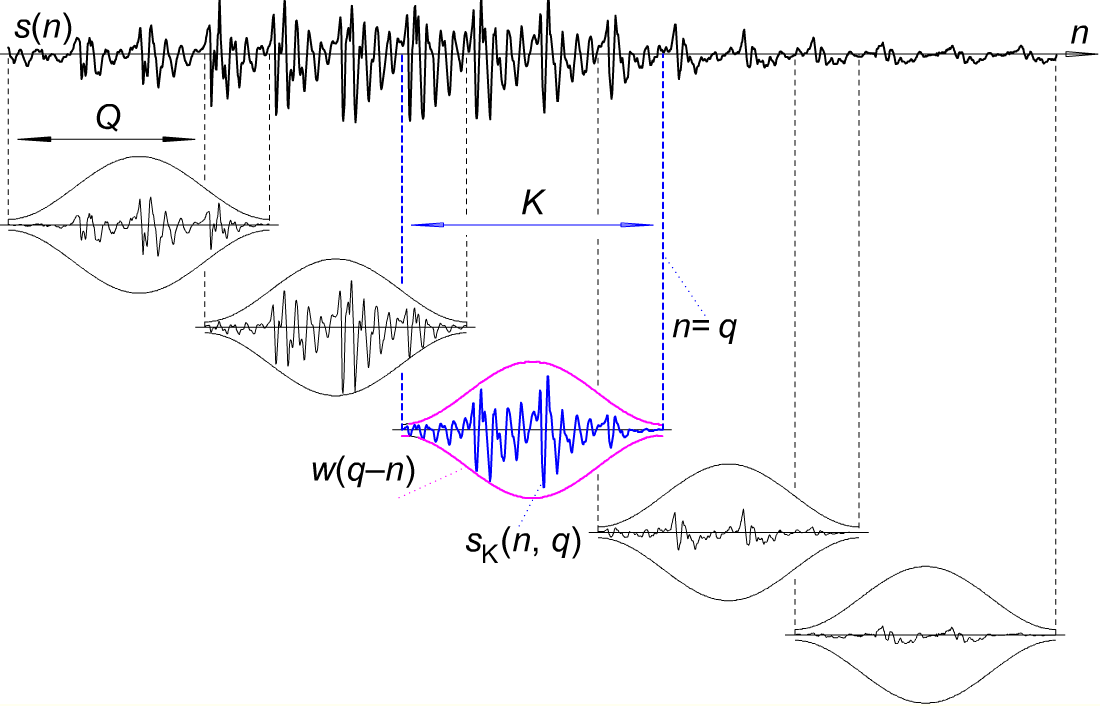

In [17]:
sample_idx = 0 # look at other samples :)
y, sr = preprocess_audio(df.iloc[sample_idx]['path'])
emotion_label = df.iloc[sample_idx]['emotion']

**1. Mel-Frequency Cepstral Coefficients (MFCC)**

They capture the spectral structure. The extraction process involves windowing the signal, applying the Fourier transform, mapping the power spectrum onto the perceptually-motivated mel scale, taking the logarithm to create the mel spectrogram, & finally computing the discrete cosine transform (DCT) to decorrelate the coefficients into the MFCC representation used by the model. The visualization below shows both the mel spectrogram & the MFCCs, but only the 13 MFCC coefficients are used as input features.

$\text{MFCC}_n = \sum_{k=1}^{K} \log(S_k) \cos\left[ n \left( k - \frac{1}{2} \right) \frac{\pi}{K} \right]$

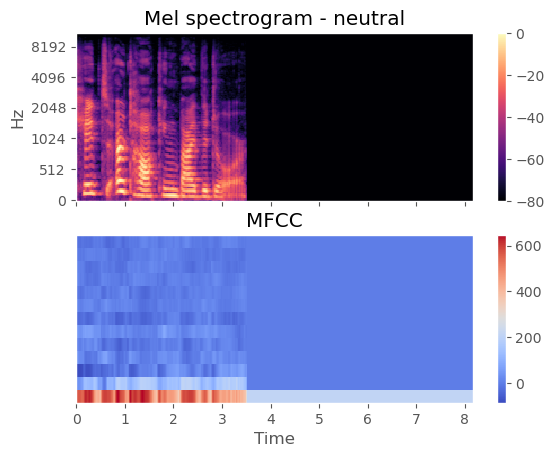

In [18]:
S = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=HOP_LENGTH)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

fig, ax = plt.subplots(nrows=2, sharex=True)

img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time', y_axis='mel', ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title=f'Mel spectrogram - {emotion_label}')
ax[0].label_outer()

img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')
plt.show()

**2. Zero Crossing Rate**

It measures how often the audio signal crosses zero amplitude. High ZCR means more noisy or hiss-like sounds; low ZCR means smoother, voiced sounds like vowels. This means ZCR can tell how "harsh" or "smooth," which is commonly associated with the emotion digust (radar plots will show this).  

$\text{ZCR} = \frac{1}{2N} \sum_{n=0}^{N-1} \left| \text{sgn}(x[n]) - \text{sgn}(x[n-1]) \right|$


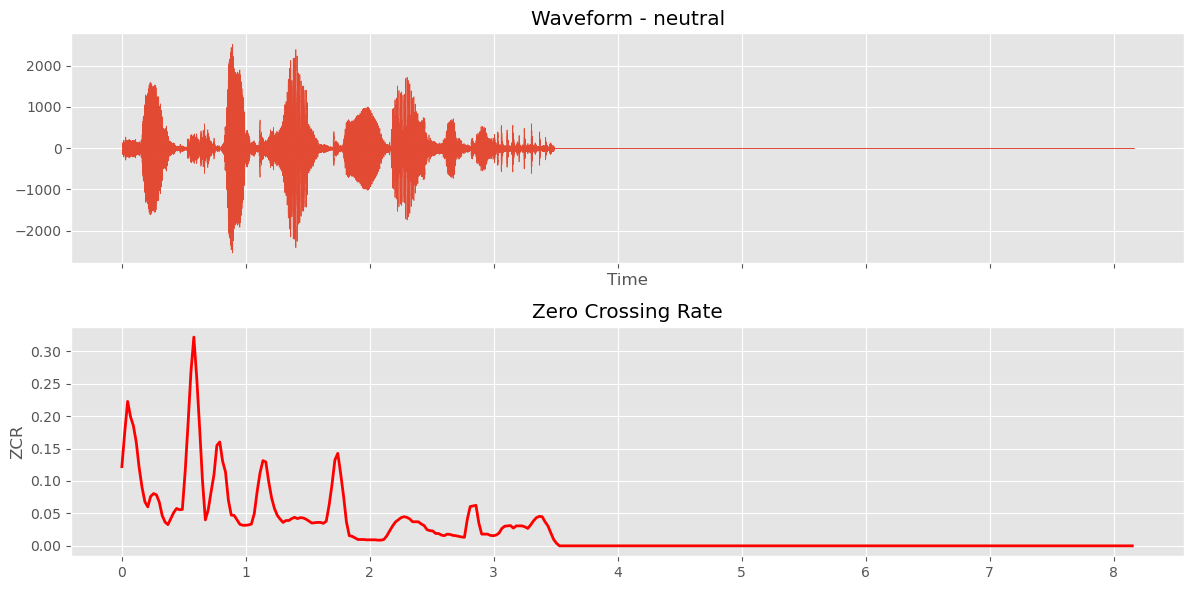

In [19]:
zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
times = librosa.frames_to_time(np.arange(len(zcr)), sr=sr, hop_length=HOP_LENGTH)

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
librosa.display.waveshow(y, sr=sr, ax=ax[0])
ax[0].set(title=f'Waveform - {emotion_label}')
ax[1].plot(times, zcr, color='red', linewidth=2)
ax[1].set(title='Zero Crossing Rate', ylabel='ZCR')
plt.tight_layout()
plt.show()

**3. Root Mean Squared** 

They measure the average energy or loudness. High RMS values indicate loud, energetic speech segments, while low values correspond to quiet or whispered speech. Thus, they help distinguish between high-energy emotions like anger or happy (high RMS) vs. low-energy emotions like sadness or neutral (low RMS). 

$\text{RMS} = \sqrt{\frac{1}{N} \sum_{n=0}^{N-1} x[n]^2}$

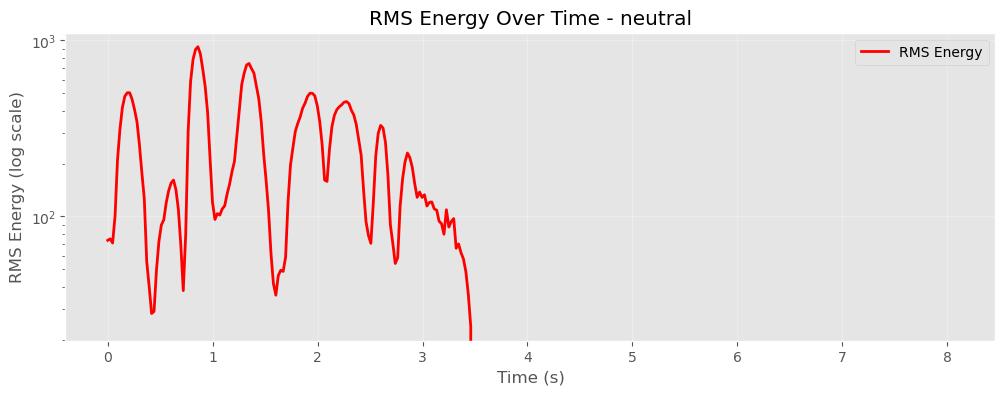

In [20]:
S = librosa.magphase(librosa.stft(y, window=np.ones, center=False, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH))[0]
rms = librosa.feature.rms(S=S)
times = librosa.times_like(rms)

plt.figure(figsize=(12, 4))
plt.semilogy(times, rms[0], label='RMS Energy', color='red', linewidth=2)
plt.title(f'RMS Energy Over Time - {emotion_label}')
plt.xlabel('Time (s)')
plt.ylabel('RMS Energy (log scale)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Shape of $X$: (samples, timesteps, features)
* samples: number of audio files
* timesteps: number of frames = 1 + floor(len(y) / HOP_LENGTH) = 352
* features: [zcr, rms, mfcc_1, mfcc_2, ..., mfcc_13] (total 15 features)

In [21]:
def extract_features(df):
    zcr_list = []
    rms_list = []
    mfccs_list = []
    emotion_list = []
    
    for row in df.itertuples(index=False):
        try: 
            y, sr = preprocess_audio(row.path)
    
            zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
            rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)
    
            zcr_list.append(zcr)
            rms_list.append(rms)
            mfccs_list.append(mfccs)
    
            emotion_list.append(encode(row.emotion))
        except Exception as e:
            print(f"Failed for path: {row.path}")
            print(f"Error: {e}")
    
    X = np.concatenate((
        np.swapaxes(zcr_list, 1, 2), 
        np.swapaxes(rms_list, 1, 2), 
        np.swapaxes(mfccs_list, 1, 2)), 
        axis=2
    )
    X = X.astype('float32')
    
    y = np.asarray(emotion_list)
    y = np.expand_dims(y, axis=1).astype('int8')

    return X, y

In terms of sex count, we have a imbalanced dataset. Furthermore, differences between sexes are biologically & behaviourally plausible, thus, I will create two models (1 male & 1 female). 

In [22]:
df_female = df[df.sex == 'female'].copy()
df_male = df[df.sex == 'male'].copy()

In [23]:
X_female, y_female = extract_features(df_female)
X_male, y_male = extract_features(df_male)

Let's create a radar plot to validate these features, seeing how spectral & temporal patterns correlation with various emotions. We could also check for outliers. 

In [24]:
from sklearn.preprocessing import MinMaxScaler

def get_means(X, y):
    if len(X) != len(y):
        return None
    
    sample_means = np.mean(X, axis=1)
    feature_names = ['ZCR', 'RMS'] + [f'MFCC{i}' for i in range(1, 14)]
    y_flat = [decode(emotion_code) for emotion_code in y.flatten()]
    
    df = pd.DataFrame(sample_means, columns=feature_names)
    df['emotion'] = y_flat
    
    emotion_means = df.groupby('emotion').mean()
    scaler = MinMaxScaler()
    emotion_norms = pd.DataFrame(scaler.fit_transform(emotion_means), index=emotion_means.index, columns=emotion_means.columns)
    
    return emotion_norms

means_female = get_means(X_female, y_female)
means_male = get_means(X_male, y_male)

print("Males: ")
print(means_female)

print("Females: ")
print(means_male)

Males: 
              ZCR       RMS     MFCC1     MFCC2     MFCC3     MFCC4     MFCC5  \
emotion                                                                         
angry    0.503562  1.000000  1.000000  0.116017  0.000000  0.079034  0.000000   
disgust  1.000000  0.144589  0.501784  1.000000  0.567450  0.482657  0.557574   
fear     0.140507  0.595494  0.736032  0.000000  0.144862  0.000000  0.278608   
happy    0.275200  0.678474  0.771217  0.376431  0.205519  0.020630  0.317553   
neutral  0.000000  0.000000  0.000000  0.488006  0.646635  0.640947  1.000000   
sad      0.181185  0.161168  0.261006  0.896615  1.000000  1.000000  0.963567   

            MFCC6     MFCC7     MFCC8     MFCC9    MFCC10    MFCC11    MFCC12  \
emotion                                                                         
angry    0.073402  0.056491  0.000000  0.240316  0.087615  0.138891  1.000000   
disgust  0.463640  0.000000  0.940115  0.000000  0.059392  0.970084  0.158642   
fear     0.061399  

Females: 


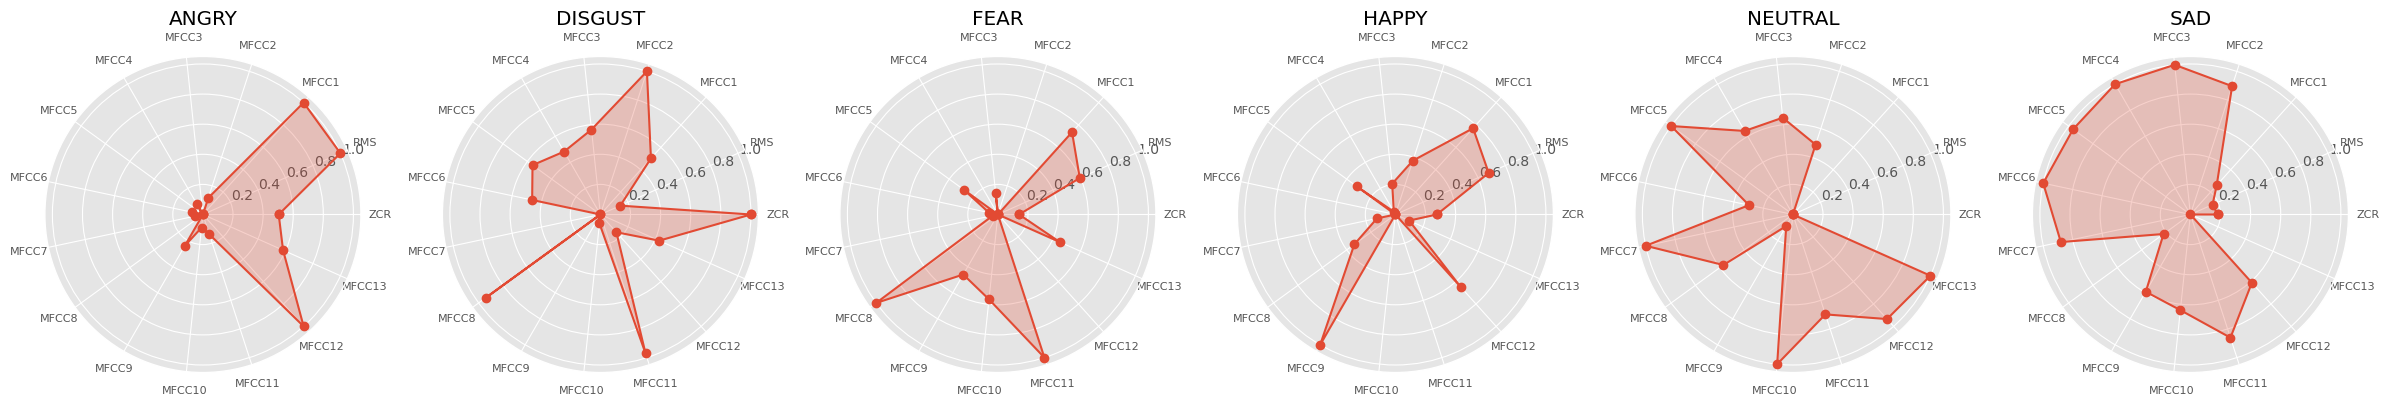

Males: 


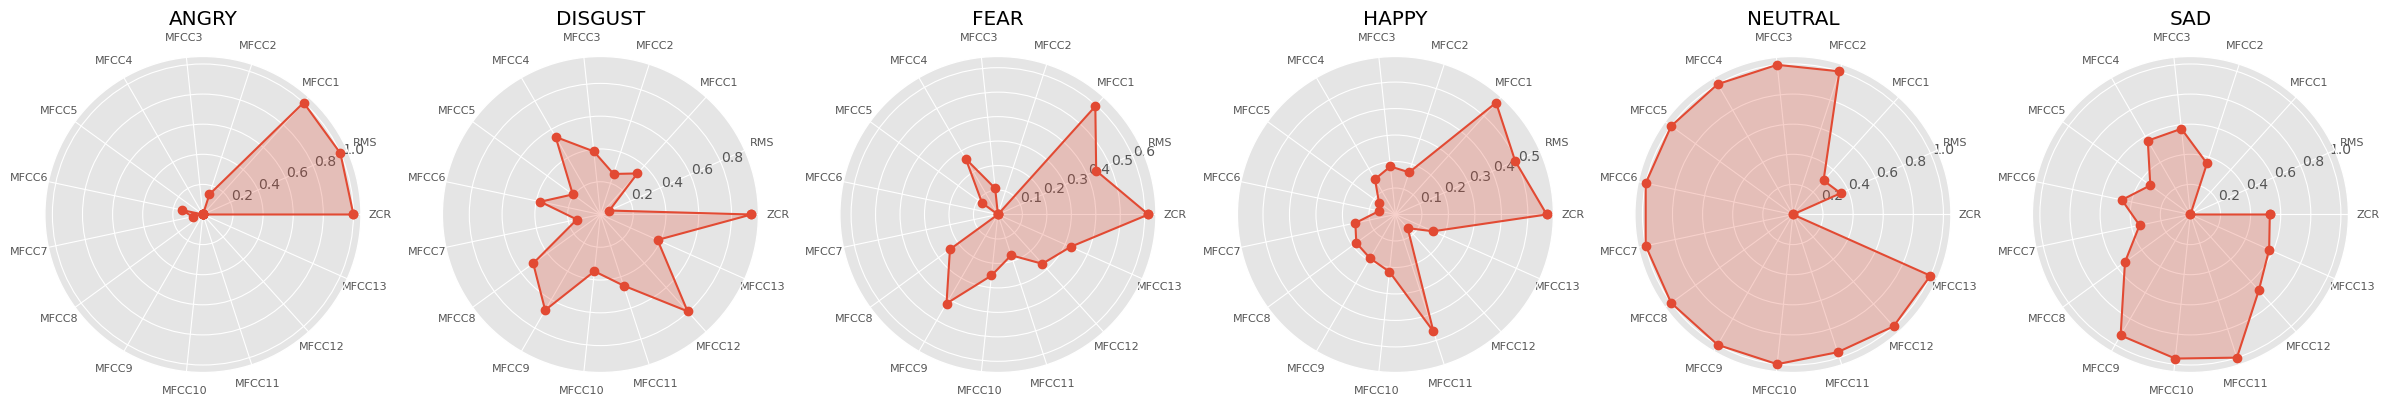

In [25]:
def radar_plot(df):
    n = len(df)
    fig, axs = plt.subplots(1, n, figsize=(4*n, 4), subplot_kw={'polar': True})
    axs = axs if n > 1 else [axs]
    
    angles = np.append(np.linspace(0, 2*np.pi, len(df.columns), False), 0)
    
    for i, (emotion, row) in enumerate(df.iterrows()):
        vals = np.append(row.values, row.values[0])
        axs[i].plot(angles, vals, 'o-')
        axs[i].fill(angles, vals, alpha=0.25)
        axs[i].set_xticks(angles[:-1])
        axs[i].set_xticklabels(df.columns, fontsize=8)
        axs[i].set_title(emotion.upper())
    
    plt.tight_layout()
    plt.show()

print("Females: ")
radar_plot(means_female)
print("Males: ")
radar_plot(means_male)

We can see many patterns: 
* High-energy emotions like angry is associated with high RMS & ZCR. 
* Calm emotions like neutral & sad emotions result with lower RMS & ZCR.
* ZCR seems to be a strong indicator for disgust (esp. for females).
* Females show the most distinctive spectral patterns in sad speech (high mfccs).
* Males exhibit neutral speech as their acoustic reference profile.
* So on ...

The most important observation is that we probably will not be able to get the same performance for the male model in comparison to the female model.

# 5. Build a LSTM

Before building the model, we will have to setup the data. LSTM are great for sequences. We will first create the female model. 

In [26]:
from keras.models import Sequential
from keras import layers, optimizers, callbacks

In [27]:
def create_model():
    MODEL = Sequential()
    MODEL.add(layers.LSTM(64, return_sequences=True, input_shape=((352, 15))))
    MODEL.add(layers.LSTM(64))
    MODEL.add(layers.Dense(6, activation='softmax'))
    
    return MODEL 

model_female = create_model()
print("Female: ")
print(model_female.summary())

model_male = create_model()
print("Male: ")
print(model_male.summary())

Female: 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 352, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 53,894
Trainable params: 53,894
Non-trainable params: 0
_________________________________________________________________
None
Male: 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 352, 64)           20480     
                                                                 
 lstm_3 (

In [28]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

In [29]:
def train(X, y, MODEL):
    X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.12, random_state=1)
    X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.3, random_state=1)
    
    y_train_class = to_categorical(y_train, 6)
    y_val_class = to_categorical(y_val, 6)

    class_weights = compute_class_weight(
        class_weight='balanced', 
        classes=np.unique(y_train), 
        y=y_train.flatten()
    )
    class_weight_dic = dict(enumerate(class_weights))
    
    early_stopping = callbacks.EarlyStopping(
        monitor='val_categorical_accuracy', 
        patience=20, 
        restore_best_weights=True
    )
    
    rlrop = callbacks.ReduceLROnPlateau(
        monitor='val_categorical_accuracy', 
        factor=0.01, 
        patience=100
    )
    
    MODEL.compile(
        loss='categorical_crossentropy', 
        optimizer='RMSProp', 
        metrics=['categorical_accuracy']
    )
    
    model = MODEL.fit(
        X_train, y_train_class, 
        epochs=200, 
        batch_size=6, 
        validation_data=(X_val, y_val_class),
        callbacks=[early_stopping, rlrop], 
        class_weight=class_weight_dic
    )

    return model, X_val, y_val

In [30]:
history_female, X_val_female, y_val_female = train(X_female, y_female, model_female)

Epoch 1/200
461/461 [==============================] - 22s 19ms/step - loss: 1.6355 - categorical_accuracy: 0.2817 - val_loss: 1.5628 - val_categorical_accuracy: 0.3258 - lr: 0.0010
Epoch 2/200
461/461 [==============================] - 8s 17ms/step - loss: 1.4866 - categorical_accuracy: 0.3732 - val_loss: 1.4083 - val_categorical_accuracy: 0.4053 - lr: 0.0010
Epoch 3/200
461/461 [==============================] - 8s 17ms/step - loss: 1.3449 - categorical_accuracy: 0.4456 - val_loss: 1.4031 - val_categorical_accuracy: 0.4432 - lr: 0.0010
Epoch 4/200
461/461 [==============================] - 8s 17ms/step - loss: 1.2689 - categorical_accuracy: 0.5009 - val_loss: 1.3142 - val_categorical_accuracy: 0.4205 - lr: 0.0010
Epoch 5/200
461/461 [==============================] - 8s 17ms/step - loss: 1.2127 - categorical_accuracy: 0.5215 - val_loss: 1.2354 - val_categorical_accuracy: 0.4621 - lr: 0.0010
Epoch 6/200
461/461 [==============================] - 8s 17ms/step - loss: 1.1680 - categoric

In [31]:
history_male, X_val_male, y_val_male = train(X_male, y_male, model_male)

Epoch 1/200
175/175 [==============================] - 7s 24ms/step - loss: 1.7499 - categorical_accuracy: 0.2230 - val_loss: 1.7973 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 2/200
175/175 [==============================] - 3s 18ms/step - loss: 1.6943 - categorical_accuracy: 0.2536 - val_loss: 1.7509 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/200
175/175 [==============================] - 3s 18ms/step - loss: 1.6648 - categorical_accuracy: 0.2861 - val_loss: 1.7852 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 4/200
175/175 [==============================] - 3s 18ms/step - loss: 1.6133 - categorical_accuracy: 0.3091 - val_loss: 1.7105 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 5/200
175/175 [==============================] - 3s 18ms/step - loss: 1.5822 - categorical_accuracy: 0.3464 - val_loss: 1.6706 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 6/200
175/175 [==============================] - 3s 18ms/step - loss: 1.5654 - categorica

# 6. Evaluate and conclude

Let's see how good are model is. 

Females: 


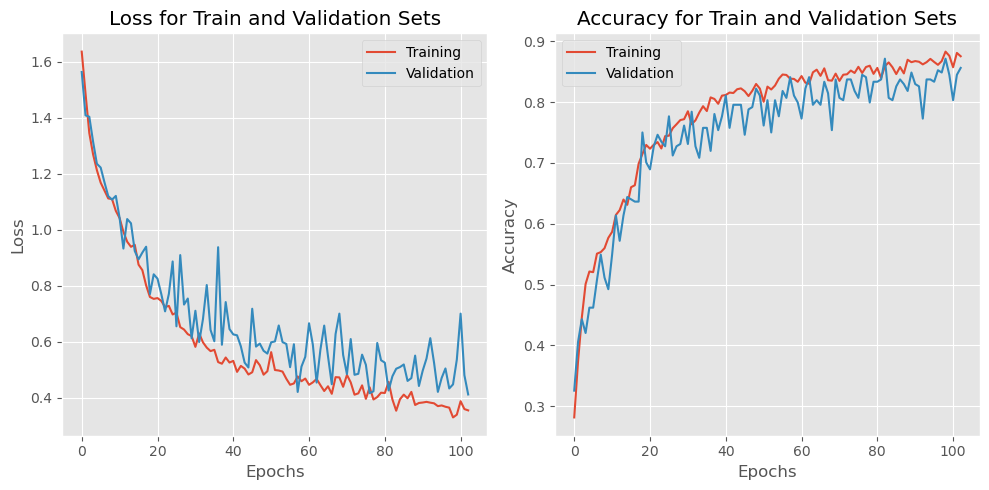

Males: 


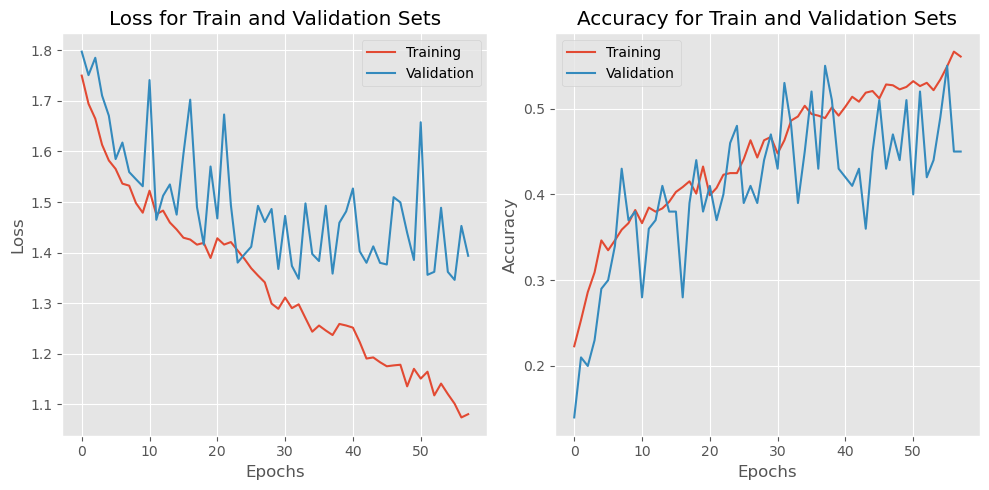

In [32]:
def create_training_history_plot(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].set_title('Loss for Train and Validation Sets')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].legend(['Training', 'Validation'])
    
    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].set_title('Accuracy for Train and Validation Sets')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend(['Training', 'Validation'])
    
    fig.tight_layout()
    
    plt.show()

print("Females: ")
create_training_history_plot(history_female)

print("Males: ")
create_training_history_plot(history_male)

We for sure need more male data. 

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

9/9 [==============================] - 1s 18ms/step


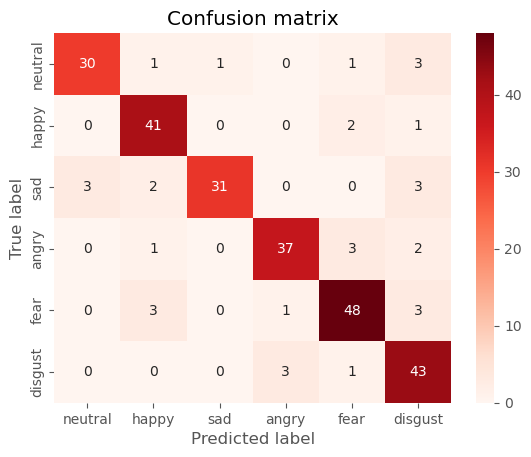

4/4 [==============================] - 1s 14ms/step


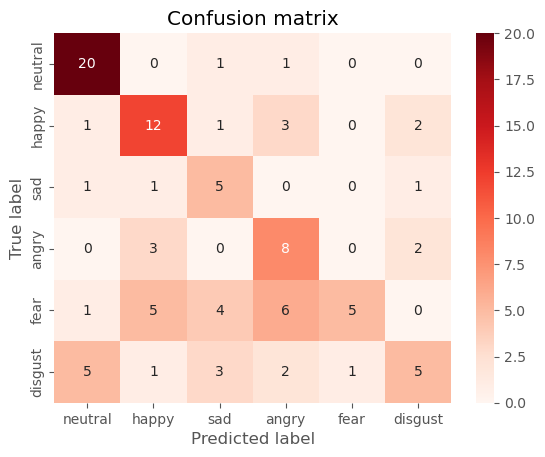

In [34]:
labels = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust'] 

def create_confusion_matrix(model, X_val, y_val):
    features = model.predict(X_val)
    y_val_class = to_categorical(y_val, 6)
    y_pred = np.argmax(features, axis=1)
    y_true = np.argmax(y_val_class, axis=1)

    cm = confusion_matrix(y_true, y_pred, labels=range(6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion matrix')
    plt.show()


create_confusion_matrix(model_female, X_val_female, y_val_female)
create_confusion_matrix(model_male, X_val_male, y_val_male)

In [35]:
def create_classification_report(model, X_val, y_val):
    features = model.predict(X_val)
    y_val_class = to_categorical(y_val, 6)
    y_pred = np.argmax(features, axis=1)
    y_true = np.argmax(y_val_class, axis=1)
    
    report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    df = pd.DataFrame(report).transpose()
    print(df.round(3))

print("Female: ")
create_classification_report(model_female, X_val_female, y_val_female)

print("Male: ")
create_classification_report(model_male, X_val_male, y_val_male)

Female: 
9/9 [==============================] - 0s 18ms/step
              precision  recall  f1-score  support
neutral           0.909   0.833     0.870   36.000
happy             0.854   0.932     0.891   44.000
sad               0.969   0.795     0.873   39.000
angry             0.902   0.860     0.881   43.000
fear              0.873   0.873     0.873   55.000
disgust           0.782   0.915     0.843   47.000
accuracy          0.871   0.871     0.871    0.871
macro avg         0.881   0.868     0.872  264.000
weighted avg      0.877   0.871     0.872  264.000
Male: 
4/4 [==============================] - 0s 18ms/step
              precision  recall  f1-score  support
neutral           0.714   0.909     0.800    22.00
happy             0.545   0.632     0.585    19.00
sad               0.357   0.625     0.455     8.00
angry             0.400   0.615     0.485    13.00
fear              0.833   0.238     0.370    21.00
disgust           0.500   0.294     0.370    17.00
accuracy     

**Conclusion**

In summary, we got 90% accuracy for females & 60% accuracy for males. In theory, if we have more data for males, we should be able to get reasonable accuracy. Please help me by upvoting :). 